# Aim

My aim is to compare Victorian Roller Derby League's performance against Australian Teams compared to International teams.  

# Details

The data is provided by Flat Track Stats, with data crowdsourced internationally. 

# Performance

Using the data available, the best measure for performance is the score difference between VRDL and their opponent. Wins and losses are determined directly by the points. While ties officially aren't possible under the WFTDA rules, they've been accounted for as part of the calcuations, just in case.

# Loading data

The data available is in 3 files.
* Teams: containing Name and location details on each team.
* Tournaments: containing date and location details on each team.
* games: containing dates and scores, linking to teams via the team id, and tournaments via the tournament IDs

The teams table needs to be merged twice to pull details for both teams. This is made easier by renaming the column headers before merging.

In [5]:
import pandas as pd
import matplotlib as mp
import datetime as dt

team = pd.read_csv("data/flattrackstats_teams_2022-03-26.csv")
tournaments = pd.read_csv("data/flattrackstats_tournaments_2022-03-26.csv")
games = pd.read_csv("data/flattrackstats_bouts_2022-03-26.csv")


team1 = team.rename(columns={'id': 'teamid1', 'name': 'name1', 'shortName': 'shortname1','abbreviation': 'abbr1','teamType': 'teamtype1', 'location':'location1', 'domain': "domain1"})
team2 = team.rename(columns={'id': 'teamid2', 'name': 'name2', 'shortName': 'shortname2','abbreviation': 'abbr2','teamType': 'teamtype2', 'location':'location2', 'domain': "domain2"})
game = games.rename(columns={'homeTeamID':'team1ID','visitorTeamID':'team2ID','homeScore':'team1score','visitorScore':'team2score'})
tournaments = tournaments.rename(columns={'name':'tournamentnname','location':'tournamentlocation','type':'tournamenttype'})
mask = game['team1ID'].isnull() | game['team2ID'].isnull() | game['team1score'].isnull() | game['team2score'].isnull()
mask2 = mask == False
cleangames = game[mask2]
gamest1 = cleangames.merge(team1, how='left', left_on='team1ID', right_on='teamid1')
gameteams = gamest1.merge(team2, how='left', left_on='team2ID', right_on='teamid2')
gtt = gameteams.merge(tournaments, how='left', left_on='tournamentID', right_on='id')

We need to determine the score difference, the winner and the date of each game. We need to determine the winner based on the scores provided. The year is being split out for grouping.

In [6]:
winner = gtt[['team1score','team2score','name1','name2']].apply(lambda x: x['name1'] if x['team1score'] > x['team2score'] else (x['name2'] if x['team1score'] < x['team2score'] else 'tie'), axis=1)
gtt.insert(2,"winner",winner)
winnerdomain = gtt[['team1score','team2score','domain1','domain2']].apply(lambda x: x['domain1'] if x['team1score'] > x['team2score'] else (x['domain2'] if x['team1score'] < x['team2score'] else 'tie'), axis=1)
gtt.insert(3,"winnerdomain",winnerdomain)
scoredifference = abs(gtt['team1score']-gtt['team2score'])
gtt.insert(4,"scoredifference",scoredifference)
gamedate = pd.to_datetime(gtt['date'])
gtt.insert(5,"gamedate",gamedate)
gameyear = gtt['gamedate'].dt.year
gtt.insert(6,"gameyear",gameyear)

# Finding VRDL games

VRDL may be team 1 or team 2, so need to be idenfied in either column. This is done by finding the ID in the teams datatable, and 

In [7]:
tmask = team['name'].str.contains('Victorian Roller Derby League')
tmask
team[tmask]

,id,name,shortName,abbreviation,teamType,location,website,parentLeague,establishedDate,disbandedDate,genus,domain
4416,6741,Victorian Roller Derby League,Victoria,VRDL,Travel Team,"Melbourne, VIC, Australia",http://www.vrdl.org/,NaN,NaN,NaN,Womens,Australia


With VRDL identified, we can isolate the games that VRDL played, as well as the ones they didn't/

In [8]:
vmask = (gtt['team1ID'] == 6741) | (gtt['team2ID'] == 6741)
vrdlgames = gtt[vmask]
nvmask = vmask == False
nvgames = gtt[nvmask]


# Determining Score Difference and Winner

To process this data from a VRDL perspective, the scores need to be changed from Team1 and Team2, to VRDL and Opponent. The winner is not explicitly provided, so this will also be derived from the higher of the two scores. The score difference will be calculated from a VRDL perspective, so will be positive for a win, and negative for a loss. This is also an opportunity to trim some unneeded columns.

In [9]:
vrdlscore = vrdlgames[['team1score','team2score','team1ID','team2ID']].apply(lambda x: x['team1score'] if x['team1ID'] == 6741 else x['team2score'], axis=1)
opponentscore = vrdlgames[['team1score','team2score','team1ID','team2ID']].apply(lambda x: x['team1score'] if x['team1ID'] != 6741 else x['team2score'], axis=1)
opponentname = vrdlgames[['name1','name2','team1ID','team2ID']].apply(lambda x: x['name1'] if x['team1ID'] != 6741 else x['name2'], axis=1)
opponentdomain = vrdlgames[['domain1','domain2','team1ID','team2ID']].apply(lambda x: x['domain1'] if x['team1ID'] != 6741 else x['domain2'], axis=1)


vrdlgames.insert(2,"vrdlscore",vrdlscore)
vrdlgames.insert(3,"opponentname",opponentname)
vrdlgames.insert(4,"opponentscore",opponentscore)
vrdlgames.insert(6,"opponentdomain",opponentdomain)
vrdlscoredifference = (vrdlgames['vrdlscore']-vrdlgames['opponentscore']) #abs
vrdlgames.insert(7,"vrdlscoredifference",vrdlscoredifference)


#vrdlgames['gamecount'] = 1

The below functions are going to help define if a game was win for VRDL, and whether their opponents were Australian or not. 

In [10]:
def vrdlwl(scoredif):
    if (scoredif > 0):
        return 'Win'
    elif (scoredif < 0):
        return 'Loss'
    else:
        return 'Tie'
    
def game_location(local):
    if (local == 'Australia'):
        return 'Local'
    else:
        return 'International'  
    
def AusVAus(domain1, domain2):
    if (domain1 == 'Australia') and (domain2 == 'Australia'):
            return True
    else:
            return False


In [11]:
vrdlwl = vrdlgames['vrdlscoredifference'].apply(vrdlwl)
vrdlgames.insert(11,"vrdlwl",vrdlwl)
gametype = vrdlgames['opponentdomain'].apply(game_location)
vrdlgames.insert(12,"gametype",gametype)


AS a point of comparison, the below will pull some other Australian teams game details, based on the volume of games played. 

In [12]:
auvau = nvgames[['domain1','domain2']].apply(lambda x: AusVAus(x['domain1'],x['domain2']), axis=1)
gw1 = nvgames[auvau][['gameyear','name1','id_x','winner','scoredifference']]
gw1 = gw1.rename(columns={'name1': 'team', 'id_x': 'gamecount'})
gw2 = nvgames[auvau][['gameyear','name2','id_x','winner','scoredifference']]
gw2 = gw2.rename(columns={'name2': 'team', 'id_x': 'gamecount'})
gwinners = pd.concat([gw1,gw2],axis=0)
gwinners['scoredifference'] = gwinners[['team','winner','scoredifference']].apply(lambda x: x['scoredifference'] if x['team'] == x['winner'] else -(x['scoredifference']), axis=1)


localgamecount = gwinners[['team','gamecount']].groupby(['team']).count().reset_index()
top5 = localgamecount.sort_values(by='gamecount',ascending=False).head(5)
localscorediff = gwinners[['gameyear','team','scoredifference']].groupby(['gameyear','team']).mean().reset_index()
localscorediff = localscorediff.merge(top5, how='inner', on=['team'])

With our fields calculated, we and categorised, we now have our working datatable for VRDL. 

In [13]:
vrdlstats = vrdlgames[['gameyear','gamedate','vrdlscore','vrdlwl','opponentname','opponentscore','opponentdomain','gametype','winner','vrdlscoredifference','tournamentnname']].reset_index()
vrdlstats

,index,gameyear,gamedate,vrdlscore,vrdlwl,opponentname,opponentscore,opponentdomain,gametype,winner,vrdlscoredifference,tournamentnname
0,646,2008,2008-02-23,86.0,Win,Adelaide Roller Derby,83.0,Australia,Local,Victorian Roller Derby League,3.0,NaN
1,2716,2009,2009-08-22,134.0,Loss,Adelaide Roller Derby,136.0,Australia,Local,Adelaide Roller Derby,-2.0,NaN
2,4077,2010,2010-06-12,234.0,Win,Sydney Roller Derby League,19.0,Australia,Local,Victorian Roller Derby League,215.0,The Great Southern Slam 2010
3,4084,2010,2010-06-12,185.0,Win,Newcastle Roller Derby League (Aus),18.0,Australia,Local,Victorian Roller Derby League,167.0,The Great Southern Slam 2010
4,4091,2010,2010-06-12,134.0,Win,Northern Brisbane Rollers,22.0,Australia,Local,Victorian Roller Derby League,112.0,The Great Southern Slam 2010
...,...,...,...,...,...,...,...,...,...,...,...,...
116,51338,2019,2019-09-21,151.0,Loss,Denver Roller Derby,206.0,USA,International,Denver Roller Derby,-55.0,2019 Thin Air Throwdown
117,51387,2019,2019-09-22,128.0,Loss,Rose City Rollers,208.0,USA,International,Rose City Rollers,-80.0,2019 Thin Air Throwdown
118,51887,2019,2019-11-15,169.0,Win,Angel City Derby,88.0,USA,International,Victorian Roller Derby League,81.0,2019 International WFTDA Championships: Montreal
119,51900,2019,2019-11-16,103.0,Loss,Gotham Roller Derby,109.0,USA,International,Gotham Roller Derby,-6.0,2019 International WFTDA Championships: Montreal


# Splitting the data

As the aim to compare VRDL's local vs international games, we need to determine the location of their opponents. This will split the data into two datatables for each group.

In [14]:
local = vrdlstats['gametype'] == 'Local'
intl = local == False

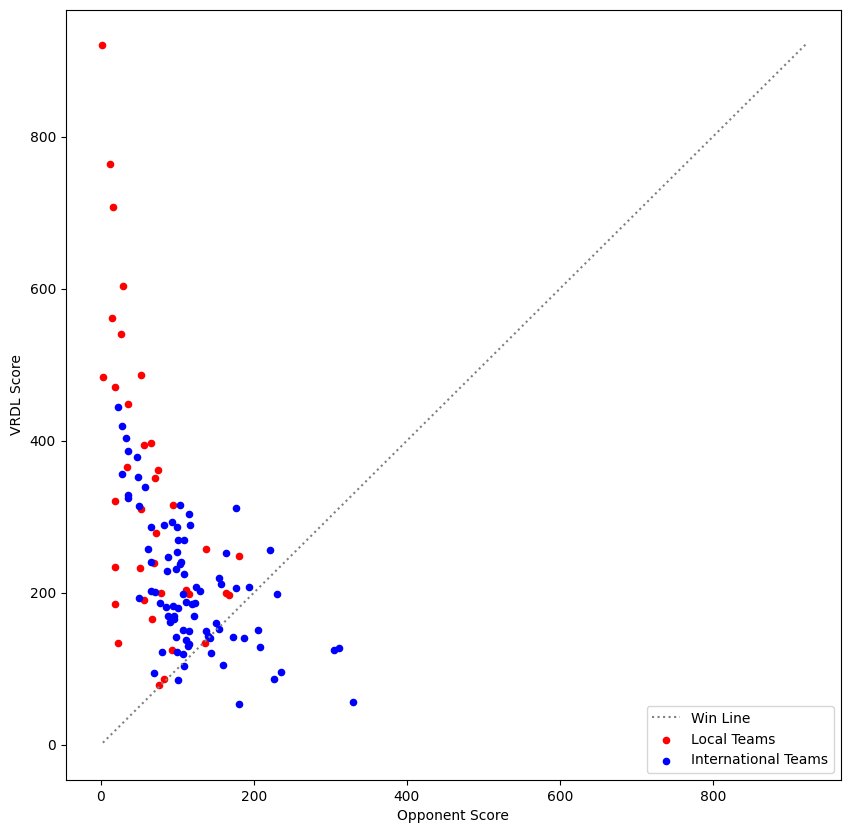

In [15]:
if max(vrdlstats['vrdlscore']) >= max(vrdlstats['opponentscore']):
    x = pd.Series([max(vrdlstats['vrdlscore'])],name='x')
    y = pd.Series([max(vrdlstats['vrdlscore'])],name='win line')
else:
    x = pd.Series([max(vrdlstats['opponentscore'])],name='x')
    y = pd.Series([max(vrdlstats['opponentscore'])],name='win line')

winaxis = pd.concat([x, y], axis=1)
zeros = {'x':[0],'win line':[0]}
zero = pd.DataFrame(zeros)
winaxis0 = pd.concat([winaxis,zero],axis=0)

vscatter = winaxis0.plot(kind="line", x='x',y='win line',color="grey", linestyle='dotted',figsize =(10,10))
vrdlstats[local].plot(kind="scatter", x='opponentscore',y='vrdlscore',color="Red",legend=True, ax=vscatter)
vrdlstats[intl].plot(kind="scatter", x='opponentscore',y='vrdlscore',color="Blue", ax=vscatter,xlabel = 'Opponent Score', ylabel = 'VRDL Score',legend=True)
mp.pyplot.legend(['Win Line','Local Teams','International Teams'])

The above scatter shows the overall success of VRDL in most of their games, but more specifically, VRDL's sheer domination over Australian teams in their recorded games. Games closer to the 'Win Line' had closer scores, and we can see that Local games lean much more heavily in VRDLs favour.

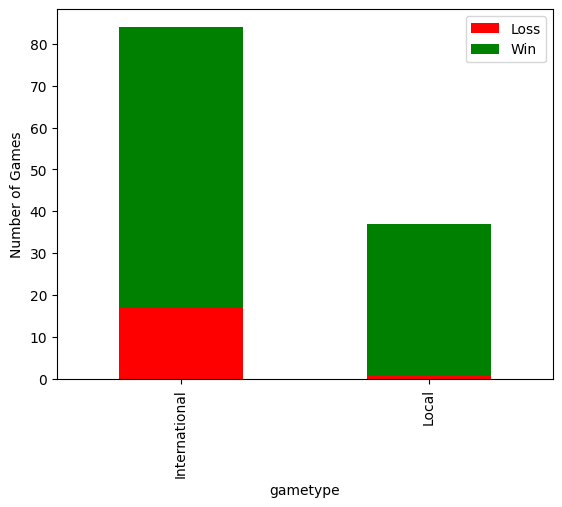

In [16]:
vwl = vrdlstats[['gametype','vrdlwl','winner']].groupby(['gametype','vrdlwl'])['winner'].count().reset_index()
vwl = vwl.rename(columns={'winner': 'gamecount'})
vwl.pivot(index='gametype',columns='vrdlwl').plot(kind='bar',ylabel='Number of Games', stacked=True,color=['Red','Green'])
mp.pyplot.legend(['Loss','Win'])

To demonstrate this further, the above shows more clearly that VRDL only have 1 recorded loss against an Australian team, and have played more international games than Local games.  For those curious, it was against Adelaide in 2009 by 2 points. They do not have a recorded Local loss since.

In [17]:
vloss = vrdlstats[local]['vrdlwl'] == 'Loss'
vrdlstats[local][vloss][['gamedate','vrdlscore','opponentname','opponentscore','vrdlscoredifference']]

,gamedate,vrdlscore,opponentname,opponentscore,vrdlscoredifference
1,2009-08-22,134.0,Adelaide Roller Derby,136.0,-2.0


To hightlight this, we can look at VRDL's yearly score difference average. 


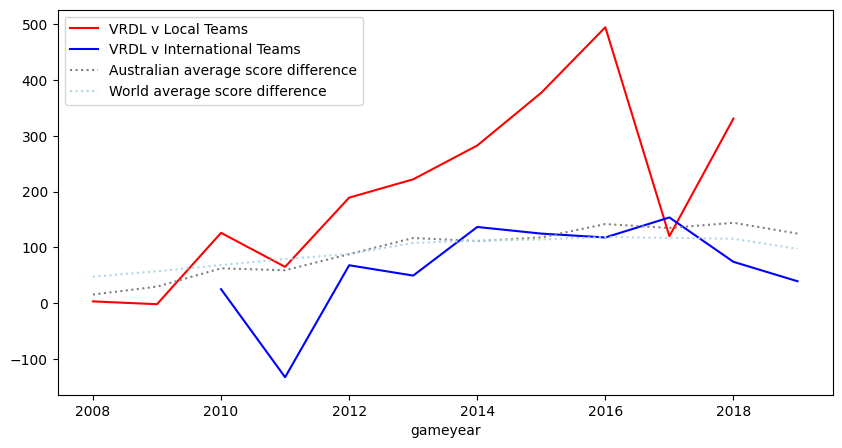

In [18]:
vavglocal = vrdlstats[local][['gameyear','vrdlscoredifference']].groupby(['gameyear']).mean()
vavgintl = vrdlstats[intl][['gameyear','vrdlscoredifference']].groupby(['gameyear']).mean()
othergames = gtt[['gameyear','scoredifference','domain1','domain2']]
ogyears = (othergames['gameyear'] >= 2008) & (othergames['gameyear'] <= 2019) #the data stretches back much further than 2008 and 2019, so this is for readibility
ogother = othergames[ogyears]
ausgames = (ogother['domain1'] == 'Australia') & (ogother['domain2'] == 'Australia')
ausavg = ogother[['gameyear','scoredifference']][ausgames].groupby(['gameyear']).mean()
worldavg = ogother[['gameyear','scoredifference']].groupby(['gameyear']).mean()
vtimeline = vavglocal.plot(kind="line", color="Red",figsize=(10,5))
vavgintl.plot(kind="line", color="Blue",ax=vtimeline)
ausavg.plot(kind="line", color="grey",ax=vtimeline,linestyle='dotted')
worldavg.plot(kind="line", color="LightBlue",ax=vtimeline,linestyle='dotted')
mp.pyplot.legend(['VRDL v Local Teams','VRDL v International Teams','Australian average score difference','World average score difference'])

we see quite a rise in difference against local teams, with international games generally landing closer to the Australian and World averages. In 2016, they were stting on roughly 5 times the average score difference for local games. 

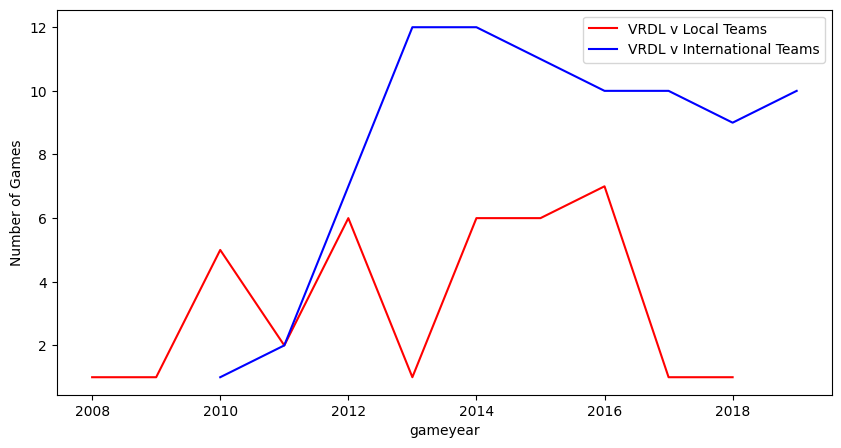

In [19]:
vclocal = vrdlstats[local][['gameyear','index']].groupby(['gameyear']).count()
vcintl = vrdlstats[intl][['gameyear','index']].groupby(['gameyear']).count()
vctimeline = vclocal.plot(kind="line", color="Red",figsize=(15,5))
vcintl.plot(kind="line", color="Blue",figsize=(10,5),ax=vctimeline, ylabel='Number of Games')
mp.pyplot.legend(['VRDL v Local Teams','VRDL v International Teams','Avg Intl Game per Local team'])

As prevously mentioned VRDL has an apparent preference for international games, at times only playing one or two games locally per year. Comparing to the score differences, this is likely due to a lack of adequate competition locally, and the ability to hold their own in international tournaments. The 2017 dip is also explained by only having played one, more evenly matched game.

<Axes: xlabel='gameyear'>

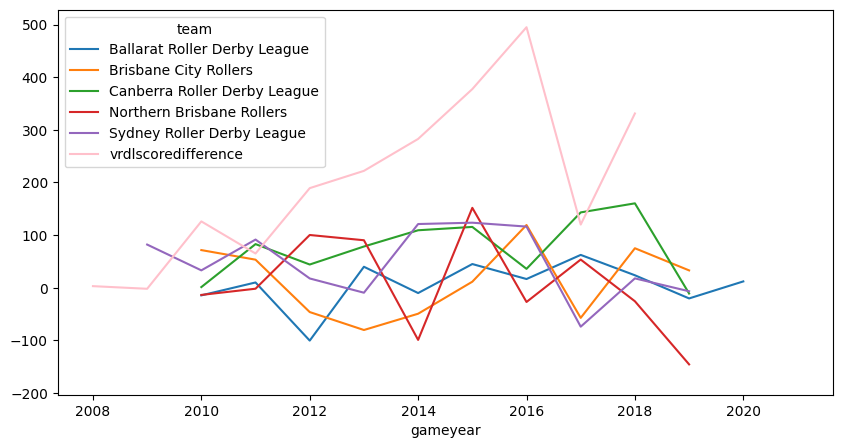

In [20]:
ax = localscorediff.pivot(values='scoredifference', index='gameyear', columns='team').plot(kind="line",figsize=(15,10))
vavglocal.plot(kind="line", color="Pink",figsize=(10,5),ax=ax)
#mp.pyplot.legend(['Brisbane City Rollers','VRDL v International Teams','Australian average score difference','World average score difference'])

The above compares VRDLs success against the Australian teams with the most number of local games in our data. What is of note is where generally these teams are averaging wins or loses with around 100 points difference, suggesting that a better quality of matches are being found for these other teams.  

Overall, VRDL persuing competition externally benefits them, the local roller derby community and fans, at least for the time being. It suits the team to find opponents that actually provide an adequite level of competition, with giving Australian fan the added bonus of having an Australian team in international competitions. But it also serves locally as having games that are complete washouts aren't particularly fun or useful to play, and for fans, not particularly entertaining to watch. 